In [239]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [240]:
# Global parameters
N = 100  # no. data points
N_iters = 1000  # max no. iterations before stopping
noise_std = 0.1
beta_tol = 1e-8  # beta tolerance for stopping iteration when |beta_new - beta_old| <= beta_tol

# Create data set
np.random.seed(2023)
x = np.random.rand(N, 1)
noise = np.random.normal(0, noise_std, x.shape)
y = 5 - 10*x + 2*x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # ??

beta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)  # own OLS inversion



# Hessian matrices 
H_ols = 2/N * X.T @ X 
eig_ols, _ = np.linalg.eig(H_ols)
print(f"OLS: 1/lambda_max={1/max(eig_ols):.3f}")

OLS: 1/lambda_max=0.401


# Plain gradient descent (GD) convergence as function of fixed learning rate

In [246]:
# GD Parameters
learn_rates = np.linspace(0.05, 1, 100, endpoint=False)

### OLS:

Beta OLS=[ 4.65168156 -8.00899928]
Best beta=[ 4.65168156 -8.00899928]


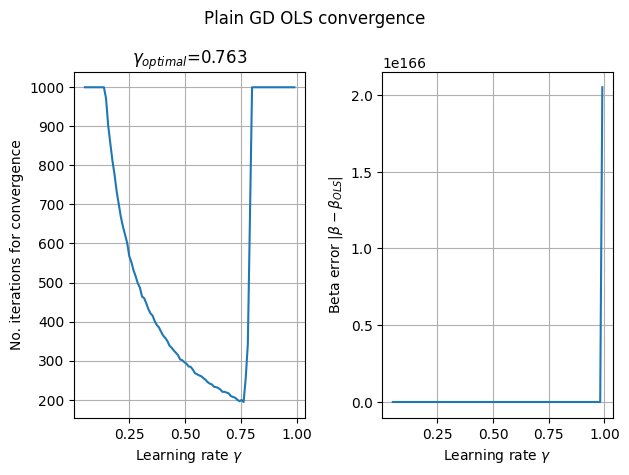

In [247]:
no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = np.random.randn(2, 1)  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        grad = 2/N * X.T @ (X @ beta - y)
        beta_prev = beta.copy()
        beta -= learn_rate * grad
        iter += 1
    no_iters[i] = iter
    
    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error


fig = plt.figure()
fig.suptitle("Plain GD OLS convergence")

# Plot convergence
plt.subplot(1, 2, 1)
plt.title("$\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
plt.plot(learn_rates, no_iters)
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("No. iterations for convergence")
plt.grid()

# Plot error
plt.subplot(1, 2, 2)
plt.plot(learn_rates, errors)
plt.xlabel("Learning rate $\gamma$")
plt.ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
plt.grid()

plt.tight_layout()

print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")

### Ridge:

In [266]:
# Parameters
ridge_lambdas = np.linspace(0.001, 1, 10)  # lambda vals to plot

XT_X = X.T @ X
I = np.identity(np.shape(XT_X)[0])
for lmbda in ridge_lambdas:
    beta_ridge = np.linalg.inv(XT_X + lmbda*I) @ (X.T @ y)  # own Ridge inversion
    print(beta_ridge.ravel())

[ 4.65095896 -8.00759474]
[ 4.57224943 -7.85462046]
[ 4.49640145 -7.7072412 ]
[ 4.42326107 -7.56515586]
[ 4.35268519 -7.42808457]
[ 4.28454063 -7.29576684]
[ 4.21870327 -7.16795993]
[ 4.15505731 -7.04443734]
[ 4.09349455 -6.92498747]
[ 4.03391383 -6.80941246]


Min no. iterations=20.0
Optimal combination (gamma, lambda)=(0.297, 1.000)
Beta ridge=[ 4.65095896 -8.00759474]
Best beta estimate=[ 4.58680319 -7.86772038]


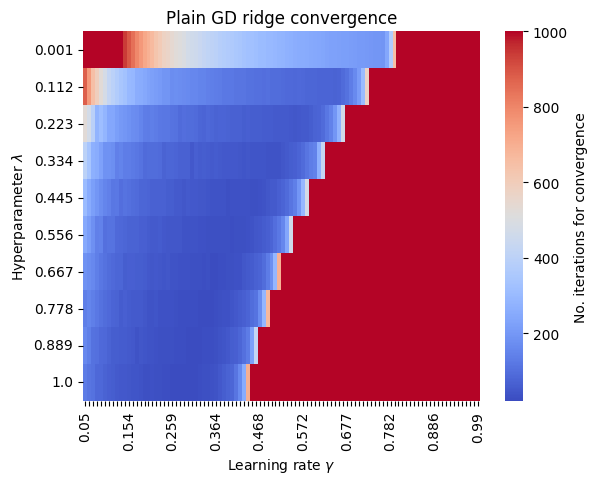

In [263]:
no_iters = np.empty((learn_rates.size, ridge_lambdas.size))  # store the number of iterations needed to converge
error_best = 1e10
beta_best = 0
beta_best_ridge = 0

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = np.random.randn(2, 1)  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            grad = 2/N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            beta_prev = beta.copy()
            beta -= learn_rate * grad
            # error = np.max(abs(beta - beta_ridge))
            # if error < error_best:
            #     error_best = error
            #     beta_best = beta
            #     beta_best_ridge = beta_ridge
            if any(beta > 1e8):  # stop if beta is blowing up -> will overflow
                iter = 1000
                break
            iter += 1
        # print(f"{lmbda=}: beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, {iter=}, {(abs(beta - beta_prev) > beta_tol).ravel()}")
        no_iters[i, j] = iter
        
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(f"Optimal combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f})")
print(f"Beta ridge={beta_best_ridge.ravel()}")
print(f"Best beta estimate={beta_best.ravel()}")

# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates)/10)+1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks)/10)+1] = keptticks

# Heatmap plot
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=ridge_lambdas,
)
plt.xticks(rotation=90)  # sideways xticks

ax.collections[0].colorbar.set_label("No. iterations for convergence")
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Hyperparameter $\lambda$");

# Momentum based GD as function of fixed learning rate

### OLS:

In [204]:
# Momentum GD Parameters
learn_rates = np.linspace(0.05, 1, 100)
momentum_rate = 0.8

Beta OLS=[ 4.65168156 -8.00899928]
Best beta=[ 4.65168156 -8.00899928]


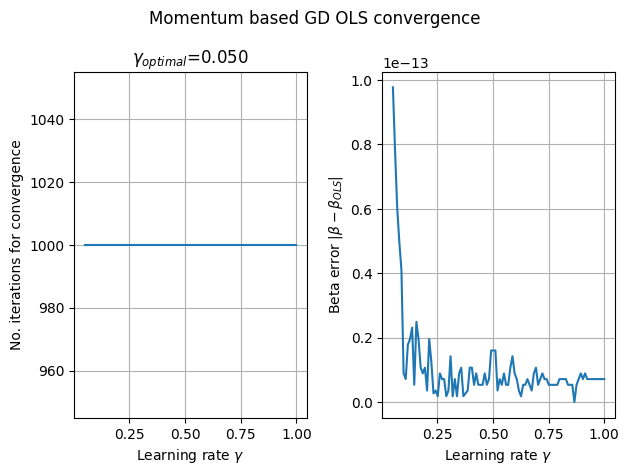

In [205]:
no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta_pp = np.random.randn(2, 1)  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_p = 2/N * X.T @ (X @ beta_pp - y)
    beta = 2/N * X.T @ (X @ beta_p - y)
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_pp = beta_p.copy()
        beta_p = beta.copy()
        grad = 2/N * X.T @ (X @ beta - y)
        beta += momentum_rate * (beta_p - beta_pp) - learn_rate * grad
        iter += 1
    no_iters[i] = iter
    
    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error
    
fig = plt.figure()
fig.suptitle("Momentum based GD OLS convergence")

# Plot convergence
plt.subplot(1, 2, 1)
plt.title("$\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
plt.plot(learn_rates, no_iters)
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("No. iterations for convergence")
plt.grid()

# Plot error
plt.subplot(1, 2, 2)
plt.plot(learn_rates, errors)
plt.xlabel("Learning rate $\gamma$")
plt.ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
plt.grid()

plt.tight_layout()

print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")

### Ridge:

In [184]:
# Iterate through and improve beta
beta_pp = np.random.randn(2, 1)
beta_p = 2/N * X.T @ (X @ beta_pp - y)
beta = 2/N * X.T @ (X @ beta_p - y)
i = 0
while i < N_iters - 2 and any(abs(beta - beta_p) > beta_tol):  # convergence test
    beta_pp = beta_p.copy()
    beta_p = beta.copy()
    grad = 2/N * X.T @ (X @ beta - y) + 2*lmbda*beta
    beta += momentum_rate * (beta_p - beta_pp) - learn_rate * grad
    i += 1
iters_mgd_ols = i
beta_mgd_ols = beta

C:\Users\Lasse\AppData\Local\Temp\ipykernel_20124\3359548841.py:9: RuntimeWarning: overflow encountered in matmul
  grad = 2/N * X.T @ (X @ beta - y) + 2*lmbda*beta
C:\Users\Lasse\AppData\Local\Temp\ipykernel_20124\3359548841.py:9: RuntimeWarning: overflow encountered in multiply
  grad = 2/N * X.T @ (X @ beta - y) + 2*lmbda*beta
C:\Users\Lasse\AppData\Local\Temp\ipykernel_20124\3359548841.py:9: RuntimeWarning: overflow encountered in add
  grad = 2/N * X.T @ (X @ beta - y) + 2*lmbda*beta
C:\Users\Lasse\AppData\Local\Temp\ipykernel_20124\3359548841.py:10: RuntimeWarning: invalid value encountered in subtract
  beta += momentum_rate * (beta_p - beta_pp) - learn_rate * grad


# Stochastic gradient descent (SDG)

In [185]:
# SDG parameters
learn_rate = 0.4
M = N/100  # size of each minibatch
m = int(N/M)  # number of minibatches
N_epochs = 50  # number of iterations over all minibatches 



# Print results

In [186]:
print(f"Own inversion:\n"
      f"1/max(OLS eigenvalues)={1/max(eig_ols):g}\n"
      f"1/max(Ridge eigenvalues)={1/max(eig_ridge):g}\n"
      f"OLS beta={beta_ols.ravel()}\n"
      f"Ridge beta={beta_ridge.ravel()}\n"
      f"Beta tolerance={beta_tol}\n"
      f"Max iterations={N_iters}\n")
print(f"Own GD code:\n"
      f"Learning rate={learn_rate}\n"
      f"OLS beta={beta_gd_ols.ravel()}\n"
      f"OLS iterations={iters_gd_ols}\n"
      f"Ridge beta={beta_gd_ridge.ravel()}\n"
      f"Ridge iterations={iters_gd_ridge}\n")
print(f"Own GD w/momentum code:\n"
      f"Learning rate={learn_rate}\n"
      f"momentum rate={momentum_rate}\n"
      f"OLS beta={beta_mgd_ols.ravel()}\n"
      f"OLS iterations={iters_mgd_ols}\n"
      f"Ridge beta={beta_mgd_ridge.ravel()}\n"
      f"Ridge iterations={iters_mgd_ridge}\n")

Own inversion:
1/max(OLS eigenvalues)=0.401248
1/max(Ridge eigenvalues)=0.398054
OLS beta=[ 4.65168156 -8.00899928]
Ridge beta=[ 4.64446663 -7.99497541]
Beta tolerance=1e-08
Max iterations=1000


NameError: name 'beta_gd_ols' is not defined